# Introduzione ai modelli di clustering
Gli algoritmi di regressione visti finora fanno parte del sottoinsieme del machine-learning detto *supervised learning* (apprendimento supervisionato), in quanto stiamo mostrando all'algoritmo un obbiettivo definito dalla nostra variabile target (e.g. stiamo indicando in fase di training quali tiri sono gol). Esistono anche algoritmi di *unsupervised learning*, dove l'obbiettivo di apprendimento dell'algoritmo non è definito in modo esplicito. Questa categoria include gli algoritmi di clustering, che consistono nel raggruppare i dati in base alle variabili a disposizione.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from database.read_db import *

Andiamo a leggere un dataset pensato appositamente per creare un modello di clustering semplificato di identificazione di ruoli/funzioni in campo. Essendo interessati a _cosa_ fa il giocatore in campo piuttosto che a _quanto bene_ lo faccia, andremo a normalizzare i nostri dati non per 90 minuti ma per 100 tocchi, nel tentativo di rimuovere il bias dovuto al fatto di giocare in squadre più o meno dominanti.

In [2]:
df = read_db('ds.player_stats_clustering').set_index(['player_id', 'team_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 433 entries, (12473, 603) to (607389, 603)
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   full_name                 433 non-null    object 
 1   team                      433 non-null    object 
 2   soccRole                  433 non-null    object 
 3   mins_played               433 non-null    int64  
 4   touches                   433 non-null    int64  
 5   open_play_pass            433 non-null    int64  
 6   total_long_balls          433 non-null    int64  
 7   total_dribbles            433 non-null    float64
 8   total_offside             433 non-null    float64
 9   header_shots              433 non-null    float64
 10  np_shots_ibox             433 non-null    float64
 11  op_shots_obox             433 non-null    float64
 12  total_through_ball        433 non-null    float64
 13  keypass                   433 non-null    fl

In [3]:
for c in df.select_dtypes(np.number).columns.to_list():
    if c not in ['mins_played', 'touches', 'full_name', 'team', 'soccRole']:
        df[f'{c}_p100'] = df[c] / df.touches * 100

# K-means clustering
Per semplicità, come primo esempio selezioniamo solo difensori centrali e terzini, e usiamo due statistiche che sono già sufficienti per distinguerli, come cross e spazzate.

In [4]:
df2 = df[df.soccRole.isin(['CB', 'FB'])]

<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

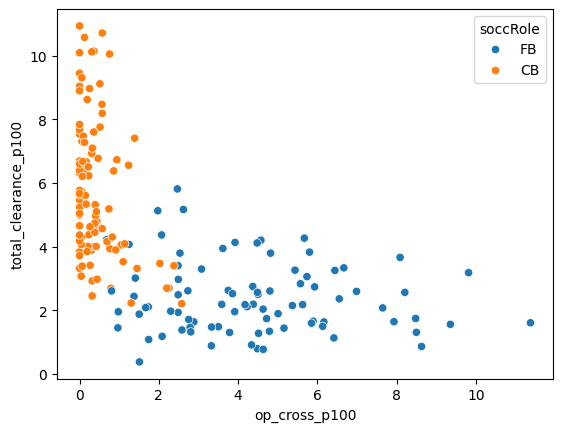

In [5]:
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'soccRole')

Vediamo che i due gruppi sono abbastanza distinti, e ci sono alcuni giocatori che sembrano classificati in modo errato, forse per via della fluidità di ruolo che esiste in alcuni casi fra terzi centrali di difesa e esterni. Vediamo come applicare un semplice algoritmo di clustering a questo caso. L'algoritmo più semplice e diffuso in questo ambito è sicuramente il *k-means clustering*. Questo algoritmo si sviluppa in modo iterativo:
* Assegnazione dei centroidi di cluster
* Assegnazione dei punti al cluster con centro più vicino
* Riassegnazione del centroide dei cluster in base alla posizione media dei punti

Questo ciclo viene ripetuto finché le assegnazioni dei punti ai diversi cluster non variano più. Nell'animazione seguente (credit: Wikipedia) vediamo un esempio del processo con tre cluster.


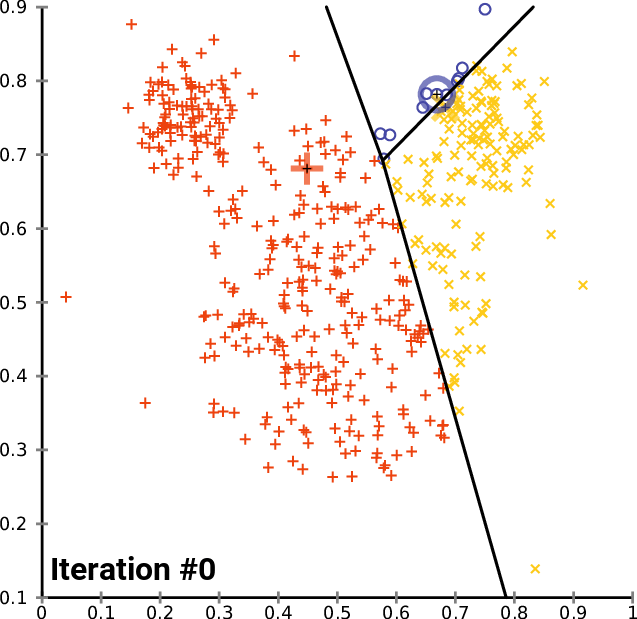

È importante tenere a mente le principali limitazioni di questo modello:
* Il numero di cluster va impostato, introducendo un bias nell'analisi nei casi in cui non si ha una classificazione di riferimento
* L'algoritmo tende a ricercare cluster di forma circolare (essendo basato solo sulla distanza dal centro) e di dimensioni simili

Il risultato del modello andrà quindi sempre visto con un occhio particolarmente critico.

Proviamo ad applicare l'algoritmo al nostro caso semplificato. Per prima cosa selezioniamo i dati, scegliendo quindi le variabili viste prima.

In [6]:
X = df2[['op_cross_p100', 'total_clearance_p100']].values

Andiamo ad applicare l'algoritmo impostando il numero di cluster pari a 2

In [7]:
kmeans = KMeans(n_clusters=2, n_init = 'auto', random_state=0).fit(X)

Andiamo quindi ad assegnare le etichette di cluster risultanti ai nostri dati, e a visualizzarli.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\382880038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clusters'] = kmeans.labels_


<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

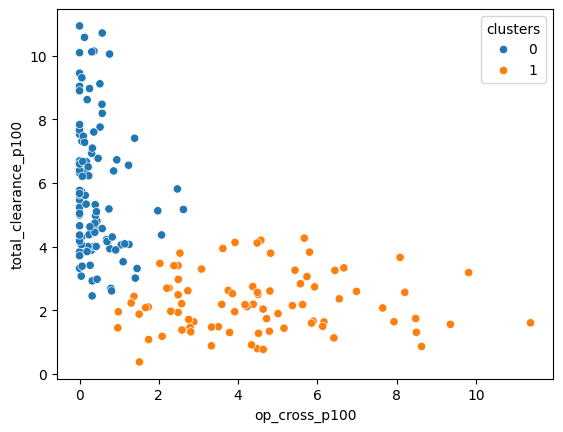

In [8]:
df2['clusters'] = kmeans.labels_
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'clusters')

Vediamo che l'algoritmo sembra aver separato correttamente i due gruppi. Come possiamo valutare la performance in questo caso? Nel caso in cui siamo convinti di avere una classificazione di riferimento corretta, ossia se nel nostro caso siamo convinti che il modello abbia come obbiettivo proprio il soccRole come compare nei nostri dati, possiamo per esempio usare  come score il cosiddetto *Adjusted Rand Index*. Dobbiamo prima convertire la nostra informazione sul ruolo in un label corrispondente a quello fornito dal clustering.

In [9]:
df2['label'] = (df2.soccRole == 'FB').astype(int)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\2749509154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = (df2.soccRole == 'FB').astype(int)


In [10]:
adjusted_rand_score(df2.label, df2.clusters)

0.7186843052803331

Questo score valuta la similarità fra le due assegnazioni, e confronta il nostro modello con un'assegnazione casuale dei labels. Il valore risultante è compreso fra -1 e +1, dove valori negativi indicano che il nostro modello fa peggio di un'assegnazione casuale, e valori positivi indicano una buona corrispondenza.

Se invece vogliamo rimanere "neutrali" sulla corretta assegnazione dei nostri dati (per necessità o per scelta), possiamo usare metriche che si focalizzano sulla struttura dei cluster e la loro coerenza interna, come il *silhouette score*. Questa metrica, anch'essa compresa fra -1 e +1, valuta positivamente cluster compatti e ben separati, confrontando la distanza fra punti nello stesso cluster con quella da punti in altri cluster.

In [11]:
silhouette_score(X, df2.clusters)

0.5126891786165172

# Soft/fuzzy clustering: Gaussian Mixture
In molti casi, non è sufficiente avere un modello che restituisca un label per i nostri cluster, ma è rilevante avere un'informazione di tipo probabilistico. Inoltre, nella maggior parte dei casi è preferibile andare a creare cluster di forma arbitraria. Infine, dover inserire in input il numero di cluster non è affatto ideale nel caso in cui vogliamo trovare delle nuove classi, piuttosto che modellare delle classi note.

Per quanto riguarda il primo punto, esistono diverse opzioni di algoritmi che restituiscono una probabilità di classificazione e non solo un label: un esempio tipico è il modello di *Gaussian Mixture* (o GMM), che cerca di modellare il dataset con una combinazione di funzioni gaussiane.

I modelli di tipo GMM forniscono già un miglioramento rispetto a K-means anche riguardo il secondo punto, ossia la forma dei cluster. Su questo aspetto, ci sono però altri algoritmi più focalizzati sulla ricostruzione di cluster ben separati ma di forma arbitraria, che vanno a formare la famiglia di *density-based clustering*, di cui l'implementazione più nota è *DBSCAN*. Lo svantaggio principale di questo tipo di modelli è la maggiore complessità e quindi minore spiegabilità, e la tendenza a classificare molti punti in aree considerate a bassa densità come rumore, non assegnandogli quindi un cluster. Inoltre nella sua versione di default DBSCAN non fornisce probabilità di classificazione.

Infine, per quanto riguarda il terzo punto, sia GMM che DBSCAN forniscono una soluzione in modo diverso: GMM richiede un numero di cluster in input, ma in alcune varianti (Bayesian Gaussian Mixture) va poi ad assegnare dei pesi, di fatto mettendo a zero il peso di cluster che ritiene non necessari. DBSCAN invece stabilisce il numero di cluster in modo autonomo, senza richiederlo in input.

L'implementazione di questi metodi in Scikit-learn è ampiamente documentata sulle pagine di aiuto della libreria:
https://scikit-learn.org/stable/modules/clustering.html

Proviamo ad applicare un modello GMM semplice all'esempio visto prima.

In [12]:
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

df2['gm_cluster'] = gm.predict(X)
df2['gm_cluster_prob0'] = gm.predict_proba(X)[:,0]
df2['gm_cluster_prob1'] = gm.predict_proba(X)[:,1]

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gm_cluster'] = gm.predict(X)
C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gm_cluster_prob0'] = gm.predict_proba(X)[:,0]
C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\3878030610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Axes: xlabel='op_cross_p100', ylabel='total_clearance_p100'>

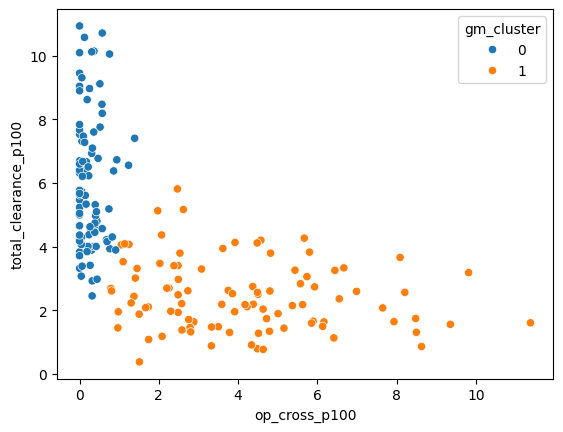

In [13]:
sns.scatterplot(data = df2, x = 'op_cross_p100', y = 'total_clearance_p100', hue = 'gm_cluster')

Vediamo che anche qui il risultato sembra buono, anche se è leggermente diverso da quello ottenuto con K-means. L'aspetto interessante di questo modello è che abbiamo estratto tramite `predict_proba` le nostre probabilità di classificazione, oltre a i label, e questo ci permette di andare a vedere se ci sono casi di giocatori ibridi.

In [14]:
df2[['full_name', 'gm_cluster', 'gm_cluster_prob0', 'gm_cluster_prob1']]

,,full_name,gm_cluster,gm_cluster_prob0,gm_cluster_prob1
player_id,team_id,,,,
21125,123,Lorenzo De Silvestri,1,0.005329,9.946714e-01
28277,128,Leonardo Bonucci,0,0.938618,6.138163e-02
39826,127,Danilo D'Ambrosio,1,0.005624,9.943757e-01
40002,127,Matteo Darmian,1,0.000047,9.999533e-01
40792,1025,Federico Fazio,0,1.000000,4.469291e-07
...,...,...,...,...,...
519394,456,Giorgio Scalvini,0,0.776358,2.236420e-01
523991,126,Isak Hien,0,0.999098,9.024685e-04
543612,128,Federico Gatti,0,0.971182,2.881808e-02


Vediamo di chi si tratta andando a filtrare per giocatori dove la probabilità massima per entrambi i cluster è meno di due terzi.

In [15]:
#isoliamo giocatori ibridi
df2['hybrid'] = df2[['gm_cluster_prob0', 'gm_cluster_prob1']].max(axis = 1) < 2./3

C:\Users\Alberto\AppData\Local\Temp\ipykernel_28036\349656006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hybrid'] = df2[['gm_cluster_prob0', 'gm_cluster_prob1']].max(axis = 1) < 2./3


In [16]:
df2[df2.hybrid][['full_name', 'soccRole', 'gm_cluster', 'gm_cluster_prob0', 'gm_cluster_prob1']]

,,full_name,soccRole,gm_cluster,gm_cluster_prob0,gm_cluster_prob1
player_id,team_id,,,,,
61118,456,Rafael Tolói,CB,1,0.350676,0.649324
89861,456,José Palomino,CB,1,0.442821,0.557179
169107,129,Adam Marusic,FB,1,0.411793,0.588207
214286,2036,Dimitrios Nikolaou,CB,0,0.545231,0.454769


# Generalizzazione a più dimensioni
Tutti questi concetti e algoritmi che abbiamo visto sono applicabili a dati con più di due dimensioni con lo stesso processo. Proviamo a generalizzare la nostra analisi includendo più variabili, e introducendo anche un passaggio di standardizzazione. Questo aiuterà l'algoritmo andando a trasformare tutte le statistiche in un range simile di valori. Matematicamente, l'operazione consiste nel sottrarre ad ogni statistica la media, e dividere per la deviazione standard. Questa operazione viene svolta dalla funzione `StandardScaler` di scikit-learn.

In [17]:
#standardizziamo i dati

vars = [x for x in df.columns if x.endswith('_p100')]

scaler = StandardScaler()
dfs = pd.DataFrame(scaler.fit_transform(df[vars].values), index = df.index, columns = vars)
dfs[['full_name', 'soccRole']] = df[['full_name', 'soccRole']]

In questo caso è chiaro che non sappiamo che numero di cluster utilizzare. Per avere una prima stima, possiamo utilizzare il cosiddetto metodo del gomito (*elbow method*). L'idea è di provare modelli con un diverso numero di cluster e andare a confrontarne gli score (in questo caso la somma del quadrato delle distanze di ogni punto dal centro del cluster), selezionando quello oltre il quale lo score smette di migliorare sensibilmente. Questo processo è implementato in modo molto pratico nella libreria `yellowbrick`, tramite la funzione `KElbowVisualizer`.

In [18]:
X = dfs[vars].values

model = KMeans(n_init = 'auto')
visualizer = KElbowVisualizer(model,
                              k=(2,20), 
                              timings = False)
visualizer.fit(X)
visualizer.show()

NameError: name 'KElbowVisualizer' is not defined

Vediamo come varia lo score in funzione del numero di cluster $k$. In questo caso l'algoritmo suggerisce 6 gruppi, ma il "gomito" non è così netto. In generale è meglio validare questo risultato usando altri metodi, uno dei quali è basato proprio sullo Silhouette score, ed è implementato sempre nella libreria `yellowbricks`.

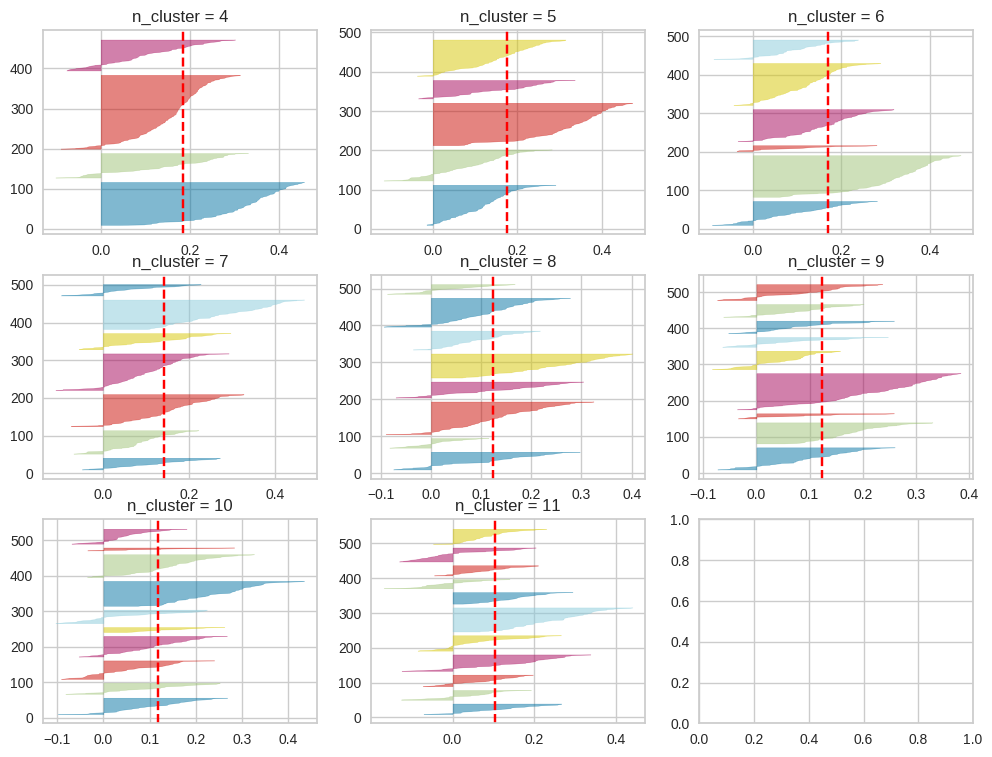

In [19]:
fig, axs = plt.subplots(3,3, figsize=(12,9))
for i,k in enumerate(range(4,12)):
  km = KMeans(n_clusters=k,n_init='auto')
  ax = axs.ravel()[i]
  
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
  ax.set_title(f'n_cluster = {k}')
  visualizer.fit(X) 
plt.subplots_adjust(hspace = 0.2)
plt.show()

Questi grafici mostrano la distribuzione del Silhouette score dei dati nei vari cluster, insieme al valore medio. In linea di massima un numero ottimale di cluster vedrebbe tutti i cluster superare il valore medio (indicato dalla linea verticale), e una distribuzione di valori abbastanza uniforme all'interno dei cluster. In questo caso vediamo che il modello non è particolarmente qualitativo, ma troviamo conferma del valore k=6 indicato dal metodo del gomito.

Proviamo ora a creare i cluster con l'algoritmo di Gaussian Mixture.

In [20]:
ncomp = 6
gm = GaussianMixture(n_components=ncomp, random_state=0).fit(X)

dfs['gm_cluster'] = gm.predict(X)
for i in range(0,ncomp):
  dfs[f'gm_cluster_prob{i}'] = gm.predict_proba(X)[:,i]

Per capire che tipo di raggruppamento abbiamo ottenuto, andiamo a vedere le statistiche mediane per i vari cluster.

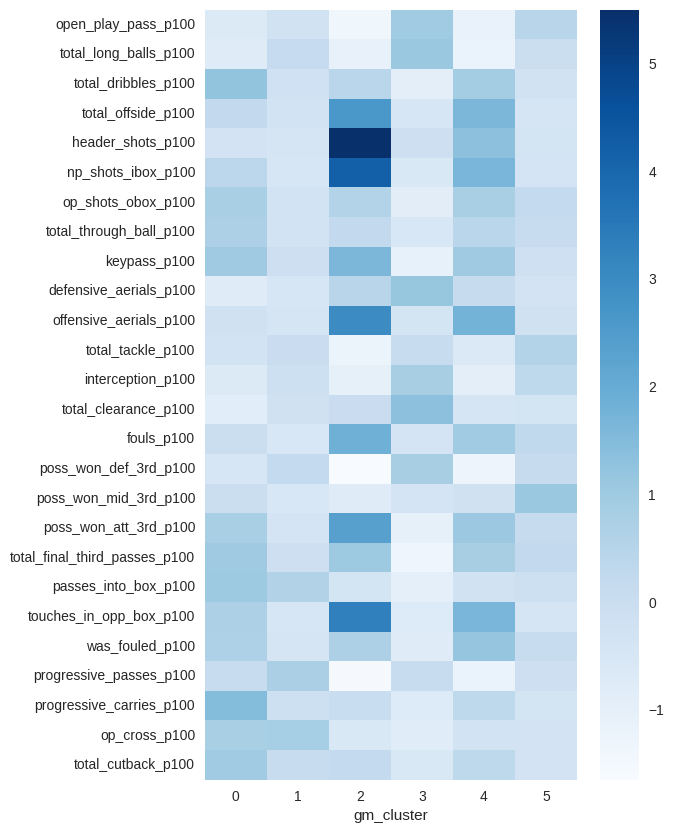

In [21]:
dfsg = dfs.groupby('gm_cluster')[vars].mean()

plt.figure(figsize = (6,10))
sns.heatmap(dfsg.T, cmap = 'Blues')
plt.show()

In [22]:
for cluster in range(0, ncomp):
    print(dfs[dfs.gm_cluster == cluster].sort_values(f'gm_cluster_prob{cluster}', ascending = False)[['full_name', 'soccRole', f'gm_cluster_prob{cluster}']].head(10))

                          full_name soccRole  gm_cluster_prob0
player_id team_id                                             
95434     136       Florian Thauvin      WAM               1.0
463788    136         Festy Ebosele       FB               1.0
179361    459        Hirving Lozano      WAM               1.0
199672    125        Jonathan Ikoné      WAM               1.0
235454    125       Riccardo Sottil      WAM               1.0
588251    2182        Luca D'Andrea      WAM               1.0
455685    2182           Emil Ceïde      WAM               1.0
488253    2036       Daniel Maldini      WAM               1.0
539199    126          Yayah Kallon      CAM               1.0
449431    2182     Armand Laurienté      WAM               1.0
                               full_name soccRole  gm_cluster_prob1
player_id team_id                                                  
431079    603            Tommaso Augello       FB               1.0
106247    2182     Giorgos Kyriakopoulos

In questo caso non è possibile andare a visualizzare in modo diretto la divisione fra i cluster come fatto in precedenza, dovendo trattare con più di due variabili. Per poterlo fare, dobbiamo applicare un algoritmo di *riduzione di dimensionalità*, che consiste nel trovare una rapprentazione che catturi e "comprima" le caratteristiche principali dei dati in meno variabili. Anche qui ci sono diversi tipi di algoritmo che si possono usare, fra cui il più noto è la cosiddetta *Principal Component Analysis*, o PCA. A livello matematico, questo algoritmo cerca di ridurre il dataset a un numero minore di variabili indipendenti, sfruttando il fatto che almeno alcune delle variabili originali hanno tipicamente un certo livello di correlazione fra loro. Vediamo come applicarlo nella sua implementazione all'interno di Scikit-learn, in questo caso inserendo esplicitamente il numero di dimensioni voluto.

In [23]:
#fit del modello PCA
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

In [24]:
#inserimento coordinate nel dataframe
dfs[['c1', 'c2']] = X_transformed

/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

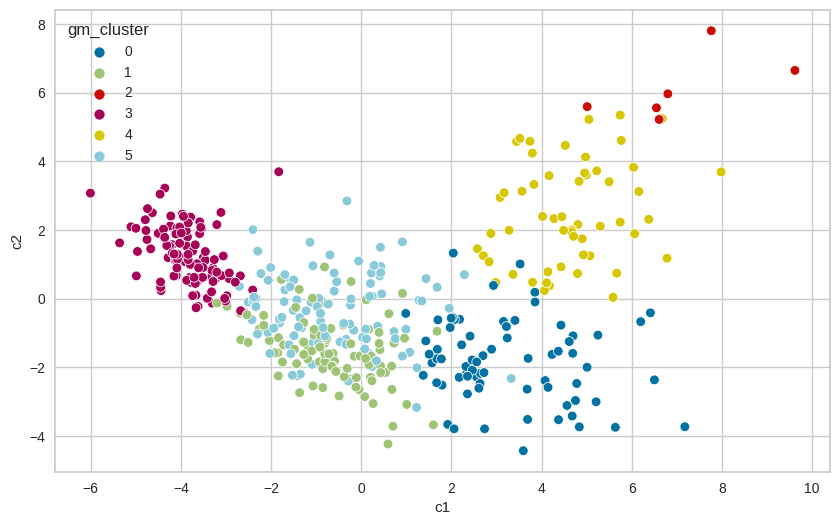

In [28]:
#trasformazione label cluster in stringa (categorico)
dfs['gm_cluster'] = dfs.gm_cluster.astype(str)

#scatterplot
f, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = dfs, x = 'c1', y = 'c2', hue = 'gm_cluster', hue_order = np.arange(0,ncomp).astype(str), ax = ax)
plt.show()

Vediamo che la divisione fra i cluster rimane più o meno visibile anche dopo questo passaggio, ma ci sono sovrapposizioni fra i cluster dovute al fatto che la riduzione di dimensionalità è comunque una rappresentazione semplificata e non completa dei dati.

Nel caso di un numero molto elevato di variabili, può essere necessario operare il passaggio di riduzione di dimensionalità prima di applicare il clustering, in quanto in uno spazio con molte dimensione le distanze fra i singoli punti tendono a dilatarsi. D'altro canto questo permette anche, in caso sia possibile rappresentare il dataset in due dimensioni, di costruire un modello visualizzabile in modo più intuitivo. Naturalmente in questo caso va verificato tramite le proprie conoscenze calcistiche che la struttura risultante abbia senso.

/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/roberto/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

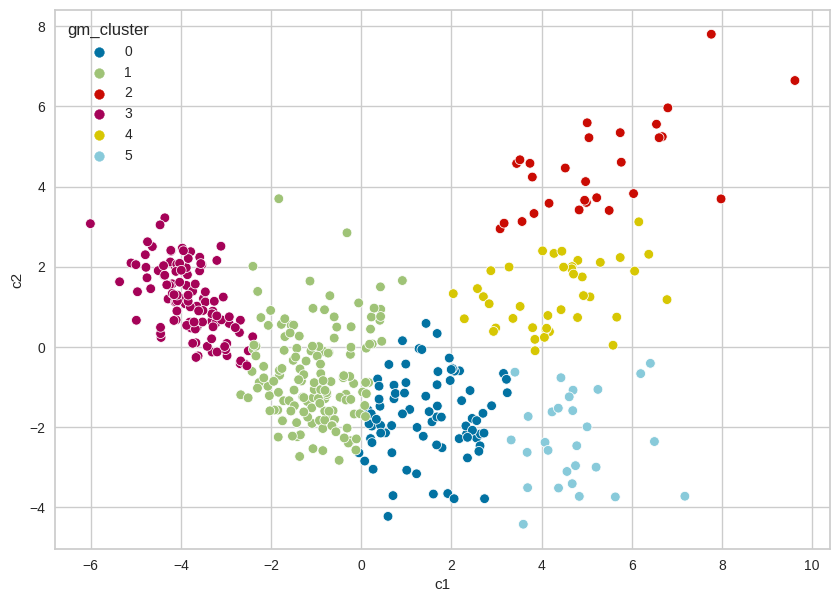

In [26]:
#clustering dopo PCA
dfs2 = dfs.copy()
gm = GaussianMixture(n_components=ncomp, random_state=0).fit(X_transformed)

dfs2['gm_cluster'] = gm.predict(X_transformed)
for i in range(0,ncomp):
  dfs2[f'gm_cluster_prob{i}'] = gm.predict_proba(X_transformed)[:,i]

#trasformazione label cluster in stringa (categorico)
dfs2['gm_cluster'] = dfs2.gm_cluster.astype(str)

#scatterplot
f, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = dfs2, x = 'c1', y = 'c2', hue = 'gm_cluster', hue_order = np.arange(0,ncomp).astype(str), ax = ax)
plt.show()

In [27]:
for cluster in range(0, ncomp):
    print(dfs2[dfs2.gm_cluster == str(cluster)].sort_values(f'gm_cluster_prob{cluster}', ascending = False)[['full_name', 'soccRole', f'gm_cluster_prob{cluster}']].head(20))

                             full_name soccRole  gm_cluster_prob0
player_id team_id                                                
184441    121       Lorenzo Pellegrini      CAM          0.941644
58928     121      Stephan El Shaarawy      WAM          0.940335
126440    459          Piotr Zielinski       CM          0.939224
61566     136          Roberto Pereyra      CAM          0.937580
49579     129                    Pedro      WAM          0.937398
476883    456            Brandon Soppy       FB          0.935891
60074     742       Marco D'Alessandro       FB          0.935422
204674    695            Nedim Bajrami      CAM          0.930806
157374    456       Ruslan Malinovskyi      CAM          0.928853
105132    603            Valerio Verre       CM          0.922333
101537    129          Felipe Anderson      WAM          0.918118
199432    127          Denzel Dumfries       FB          0.909510
430529    2174         Emanuele Valeri       FB          0.907251
153867    